# Minimalistic HHL linear solver

## Implementation in `qiskit`

`qiskit` has an implementation of the hhl algorithm.
It can be imported using:

In [1]:
from qiskit.algorithms.linear_solvers.hhl import HHL

## Minimal example

We'll begin by importing a couple of dependencies.

In [2]:
import numpy as np
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver

## Problem posing

We'll solve a simple linear system of the form:

$$
A \vec x = \vec b
$$

where:

$$
A =
\begin{bmatrix}
a & b \\
b & a
\end{bmatrix}
:
a = 1,
b = -\frac{1}{3}
$$

and

$$
\vec b = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$

This example is based on the [`qiskit` tutorials](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html), which in turn is based on [this publication](https://arxiv.org/abs/2108.09004).

In [3]:
a = 1
b = -1/3
matrix = np.array([[a, b], [b, a]])
vector = np.array([1, 0])

### Classical solution

Keep in mind that during the encoding the vector will be normalized.
This means that the equivalent classical problem would be that of:

$$
A\vec x = \frac{\vec b}{\| \vec b\|} \equiv \hat b
$$

In [4]:
nvector = vector / np.linalg.norm(vector)
classical_solution = NumPyLinearSolver().solve(matrix, nvector)
print(classical_solution)

{   'circuit_results': None,
    'euclidean_norm': 1.1858541225631423,
    'observable': None,
    'state': array([1.125, 0.375])}


The solution is given by:

In [5]:
exact_solution = classical_solution.state
print(exact_solution)

[1.125 0.375]


We can check that the classical solution $\vec s$ is correct by evaluating ensuring that:

$$
A \vec s - \hat b = \vec 0
$$

In [6]:
assert np.max(np.matmul(matrix, classical_solution.state) - nvector) == 0.0

## HHL solution

The `HHL` method has a very similar interface to that of `NumPyLinearSolver`, but applied naively, it will return the circuit instead of the solution:

### Naive approach

In [7]:
naive_hhl_solution = HHL().solve(matrix, vector)

Printing the circuit may be a good idea:

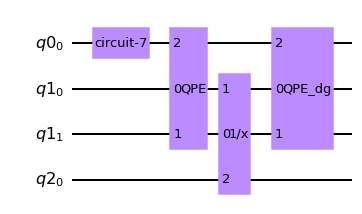

In [8]:
qc = naive_hhl_solution.state
qc.draw()

## Brute force approach

This is the only way I managed to make it work.
For a more details about how I reached this conclusions, please see the [exploratory analysis](./hhl_toymodel.ipynb).

## Simulate locally

We'll use `transpile` to rewrite our circuit exclusively in terms of basic gates:

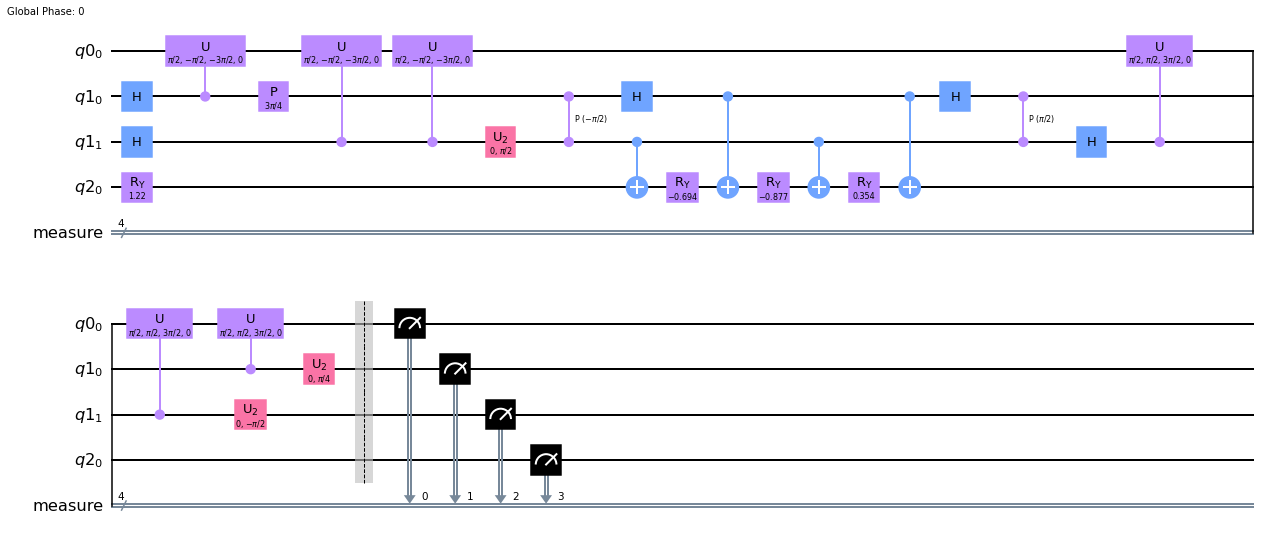

In [9]:
from qiskit import Aer, transpile

sim = Aer.get_backend('aer_simulator')

circ = transpile(qc, sim)
circ.measure_active()
circ.draw()

Now we can simulate the circuit.

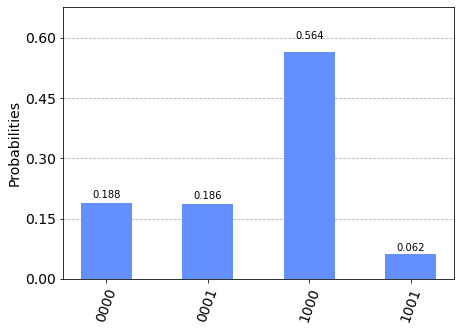

In [10]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

shots = 100000
result = sim.run(circ, shots=shots).result()
counts = result.get_counts()

plot_histogram(counts)

The solution is encoded in the coefficients of $\ket{1000}$ and $\ket{1001}$.
We can extract the absolute value of their coefficients by taking the square root of their measured probabilities.

In [11]:
""" Auxiliary function. Reads the probability of a given state"""
def get_prob(key):
    return counts.get(key) / shots

probs = [get_prob("1000"), # These are our only probabilities of interest
         get_prob("1001")]

unsignedcoefs = np.sqrt(probs)

print("Probabilities : ", probs)
print("Coefficients  : ", unsignedcoefs)

Probabilities :  [0.56371, 0.06225]
Coefficients  :  [0.75080623 0.2494995 ]


The circuit introduces a renormalization, but the ratio between both coordinates should remain constant:

In [12]:
print(unsignedcoefs[0] / unsignedcoefs[1])
print(exact_solution[0] / exact_solution[1])

3.009249462792553
3.0000000000000004


## Simulate remotely

### Authenticate and login

In [13]:
# Your personal and confidential token
ibmq_token = ## <--- Insert your token here

# Some extra information
hub = 'ibm-q-qal' # Which hub to use
group = 'escience' # Your working group's id
project = 'qradio' # Your project's id

In [14]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

IBMQ.enable_account(ibmq_token)
provider = IBMQ.get_provider(hub=hub, group=group, project=project)

# Inspect all backends
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q-qal', group='escience', project='qradio')>]


In [15]:
# Select the less busy backend and get its status
from qiskit.providers.ibmq import least_busy

backend = least_busy(provider.backends())
backend.status()

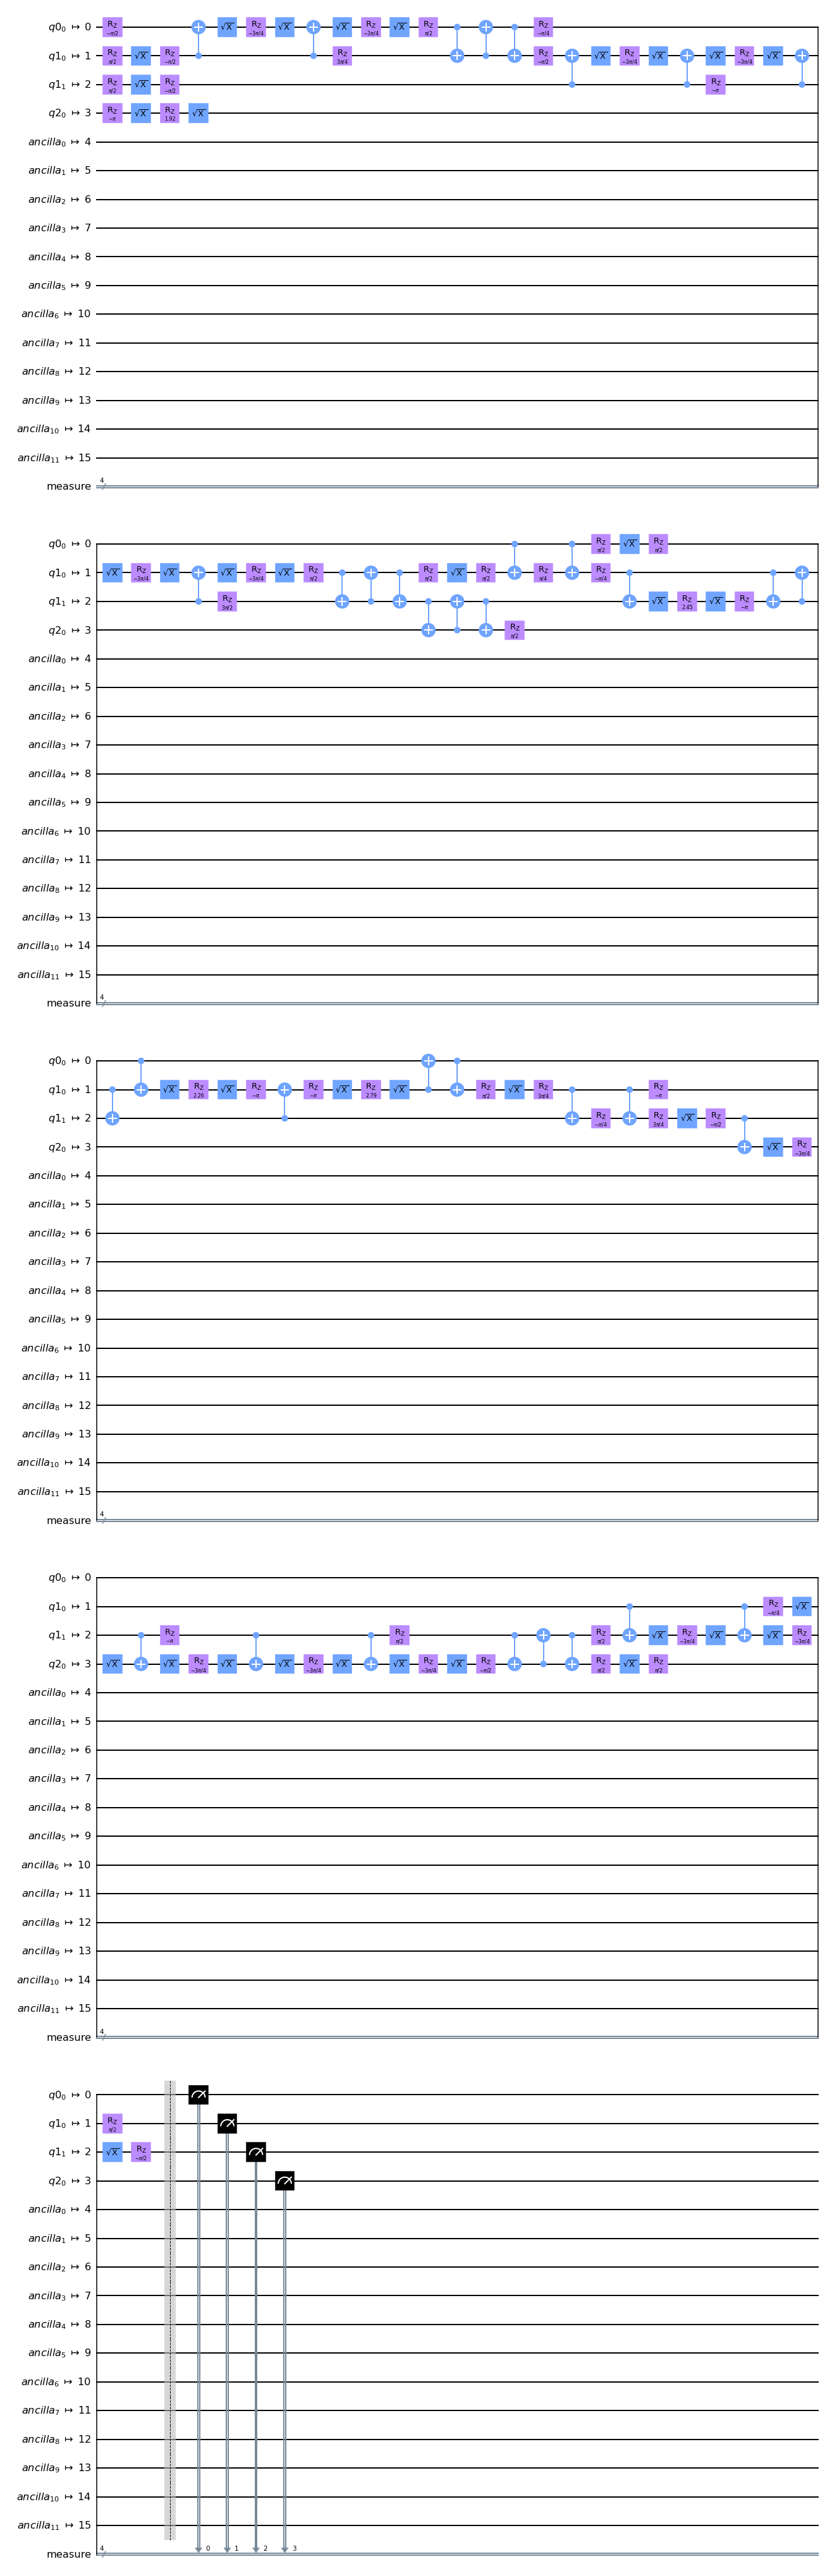

In [16]:
circ = transpile(qc, backend) # Transpile the circuit to the given backend
circ.measure_active()
circ.draw()

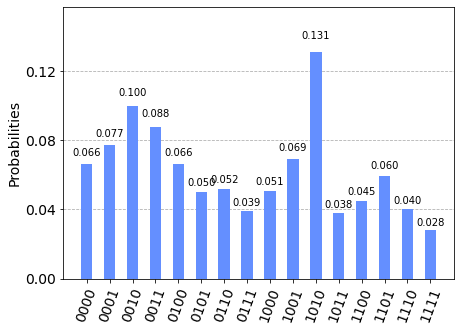

In [17]:
shots = 1024
result = backend.run(circ, shots=shots).result()
counts = result.get_counts()

plot_histogram(counts)

In [18]:
probs = [get_prob("1000"), # These are our only probabilities of interest
         get_prob("1001")]

unsignedcoefs = np.sqrt(probs)

print("Probabilities : ", probs)
print("Coefficients  : ", unsignedcoefs)

Probabilities :  [0.05078125, 0.0693359375]
Coefficients  :  [0.22534695 0.26331718]


In [19]:
print(unsignedcoefs[0] / unsignedcoefs[1])
print(exact_solution[0] / exact_solution[1])

0.8558004242796231
3.0000000000000004
